In [1]:
wd = "/exports/reum/dvanderbijl/"
data_dir_david = "/home/dljsteeman/SQUEEZE_WP2_export/20231205_Nils/"
results_dir = "/exports/reum/nsteinz/results/"
data_dir_old = "/exports/reum/nsteinz/data/data_03_12_22/"
__VERSION__ = 1.1

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances

In [2]:
import __init__ # set up all the correct referenses
import os

subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output"
print(results_dir)


/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output


In [3]:
# PREDNISOLONE mogelijk
dmards = ['ABATACEPT', 'ADALIMUMAB', 'ANAKINRA',
       'SODIUM_AUROTHIOMALATE', 'AZATHIOPRINE', 'BARICITINIB',
       'CERTOLIZUMAB_PEGOL', 'CICLOSPORINE', 'CYCLOPHOSPHAMIDE', 'ETANERCEPT',
       'GOLIMUMAB', 'HYDROXYCHLOROQUINE', 'INFLIXIMAB', 'LEFLUNOMIDE',
       'METHOTREXATE', 'SULFASALAZINE',
       'TOCILIZUMAB', 'TOFACITINIB']

dmard_types = {
    "TNF_b_dmards" : ['ETANERCEPT', 'GOLIMUMAB','INFLIXIMAB','CERTOLIZUMAB_PEGOL', 'ADALIMUMAB'],
    "IL6_b_dmards" : ['CERTOLIZUMAB_PEGOL', 'TOCILIZUMAB'],
    "IL1_b_dmards" : ['ANAKINRA'],
    "tcell_b_dmards" : ['ABATACEPT'],
    "cs_dmards" : ["METHOTREXATE",'HYDROXYCHLOROQUINE','LEFLUNOMIDE', 'SULFASALAZINE'],
    "jak_dmard" : ['TOFACITINIB', 'BARICITINIB'],
    "XO_damrd" : ['AZATHIOPRINE'],
    "OP_dmard" : ["CYCLOPHOSPHAMIDE"],
    "TC_dmard" : ["CICLOSPORINE"],
    "gld_dmard": ["SODIUM_AUROTHIOMALATE"]
    #"predni":  ['PREDNISOLONE',"METHYLPREDNISOLONE"],
}
predni = ['METHYLPREDNISOLONE', 'PREDNISOLONE']

In [4]:
mapping_pid = pd.read_csv("/exports/reum/nsteinz/code/preprosses/old_to_new_patient_mapping.csv")


In [5]:
#data_use = pd.read_csv("/exports/reum/nsteinz/results/" +"merged_new_data.csv")
data_use_new = pd.read_csv('/exports/reum/nsteinz/Project_trajectories/trajectories/data/Leiden_mannequine_file.csv')
data_use_new["DATUM"] = pd.to_datetime(data_use_new["DATUM"])


In [6]:
dmards = pd.read_csv(data_dir_david+"dmards_squeeze_2023_cleaned.csv", sep = ";" )

/tmp/ipykernel_892523/829424884.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dmards = pd.read_csv(data_dir_david+"dmards_squeeze_2023_cleaned.csv", sep = ";" )


In [7]:
das_full = pd.read_csv(data_dir_david+"mannequin_squeeze_2023_cleaned.csv", sep = ";" )
das_full["visit_date"] = pd.to_datetime(das_full["visit_date"])

In [8]:
das_new = das_full.merge(mapping_pid, how="left")

In [9]:
das_old = data_use_new.merge(mapping_pid, how="left")

In [10]:
datasamples_use =  pd.read_csv(data_dir+"/predictie_data.csv",)



In [11]:
pec = das_full.sort_values("visit_date" ).groupby("patient_id").head(1)[["patient_id","visit_date"]]
pec.columns=["patient_id","PEC"]
das_full = das_full.merge(pec)
das_full["delta_time"] = (das_full.visit_date - das_full.PEC).dt.days

In [12]:
lab = pd.read_csv(data_dir_david+"observations_squeeze_2023_cleaned.csv", sep = ";" )
lab["visit_date"] = pd.to_datetime(lab["visit_date"])
lab.columns
lab["MCV"] = (lab['Hematocrit (L/L)']/ lab["Erythrocytes (10*12/L)"] * 1000).round(2)


/tmp/ipykernel_892523/1928379776.py:1: DtypeWarning: Columns (17,29,63) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.read_csv(data_dir_david+"observations_squeeze_2023_cleaned.csv", sep = ";" )


In [13]:
lab_ = pd.read_csv(raw_data_dir+"data_03_12_22/"+"NewPatSelection_Lab_20221202.csv", sep = "|")

lab_ = lab_.drop(lab_.query("uitslag_unit=='/uL'").index)
lab_ = lab_.drop(lab_.query("uitslag_unit=='/µL'").index)
lab_ = lab_.drop(lab_.query("test_naam_omschrijving=='Lymfocyten' & uitslag_unit == '%'").index)
lab_ = lab_.drop(lab_.query("test_naam_omschrijving=='Monocyten' & uitslag_unit == '%'").index)
lab_.drop(lab_.query("uitslag_unit=='10*6/L'").index)
lab_.drop(lab_.query("uitslag_unit=='x10^6/L'").index)
lab_copy = lab_.copy()
#print()
lab_.Monster_Afname_Datumtijd = pd.to_datetime(lab_.Monster_Afname_Datumtijd)
# fix some spelling mistakes
lab_.test_naam_omschrijving = (lab_.test_naam_omschrijving
        .copy()
        .replace("Hb", "Hemoglobine")
        .replace("Ht", "Hematocriet")
        .replace("Hematocriet [CKCL]", "Hematocriet")
        .replace("Hemoglobine [CKCL]", "Hemoglobine")
        .replace("C-Reactief Proteine", "C-Reaktief Proteïne")

       )

lab_.uitslag_value = (lab_.uitslag_value
                    .replace("NaN", 0)
                    .fillna(0)
                    .astype(np.float32))
#print(lab_.uitslag_text )
lab_.uitslag_text = pd.to_numeric(lab_.uitslag_text
                     .replace("Positief", 100)
                     .replace("Negative", 1)
                     .replace("Positive", 100)
                     .replace("Negatief", 1)
                     .replace(">340", 341)
                     .replace(">200", 201)
                     .replace("<3", 2)
                     .replace("<3.0", 2)  

                     ,errors='coerce'
                  ).fillna(0)

# dit veroorzaakt negatieve waardes
lab_.uitslag_value = (lab_.uitslag_value + lab_.uitslag_text)

lab= lab_.pivot_table(index=["PATNR","Monster_Afname_Datumtijd"], 
                columns="test_naam_omschrijving", 
                values="uitslag_value",
                ).reset_index()
lab_names = lab.columns[2:]
lab["IgM reumafactor"]
lab = lab.rename(columns={"Anti-CCP":"Anti_CCP", "Anti-CCP Kwant.":"Anti_CCP_kwant", 'IgM reumafactor':'IgM_reumafactor'})
#lab.query("PATNR == 304816915")
lab

lab["acpa_pre"] = (lab[["Anti_CCP","Anti_CCP_kwant"]].sum(axis=1, min_count=1) > 9) * 1
acpa = (lab.groupby("PATNR").acpa_pre.max()== 1).to_frame().rename(columns={"acpa_pre":"acpa"})
RF = (lab.groupby("PATNR").IgM_reumafactor.max()>= 20).to_frame().rename(columns={"IgM_reumafactor":"RF"})

lab = lab.merge(RF, how="left", left_on="PATNR", right_on="PATNR")
lab = lab.merge(acpa, how="left", left_on="PATNR", right_on="PATNR")
lab["seropos"] = lab[["RF","acpa"]].sum(axis=1) >=1
lab.groupby("PATNR").seropos.max().sum()



1111

In [14]:
lab_features = ["BSE", "Leukocyten", 'Trombocyten', 'Hemoglobine', 'Hematocriet', "MCV"]
features_use = ["sjc28", "tjc28"] + lab_features

In [15]:

pred = pd.read_csv(data_dir_david+"prednisolone_squeeze_2023_cleaned.csv", sep = ";" )


In [16]:
lab_features =['BSE',
            #'C-Reaktief Proteïne',
            'Leukocyten',
            #'Hematocriet',
            'Hemoglobine',
            #'IgM reumafactor',
            #'MCH',
            #'MCHC',
            'MCV',
            'Trombocyten',]
test_mergasof = pd.merge_asof(
    das_old.sort_values("DATUM"),
    lab.sort_values("Monster_Afname_Datumtijd"),
    left_on="DATUM",
    right_on="Monster_Afname_Datumtijd",
    by="PATNR",
    tolerance=pd.Timedelta("14D"),
    allow_exact_matches=True,
    direction = "nearest"
)

Index(['PATNR', 'Monster_Afname_Datumtijd', 'Alkalische Fosfatase', 'Anti_CCP',
       'Anti_CCP_kwant', 'BSE', 'Basofielen', 'Basofielen #',
       'C-Reaktief Proteïne', 'Eosinofielen', 'Eosinofielen #', 'Ferritine',
       'Hematocriet', 'Hemoglobine', 'IJzer', 'IgM_reumafactor', 'Leukocyten',
       'Lymfocyten', 'Lymfocyten #', 'MCH', 'MCHC', 'MCV', 'Monocyten',
       'Monocyten #', 'Neutrofielen', 'Neutrofielen #', 'Trombocyten',
       'acpa_pre', 'RF', 'acpa', 'seropos'],
      dtype='object')


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

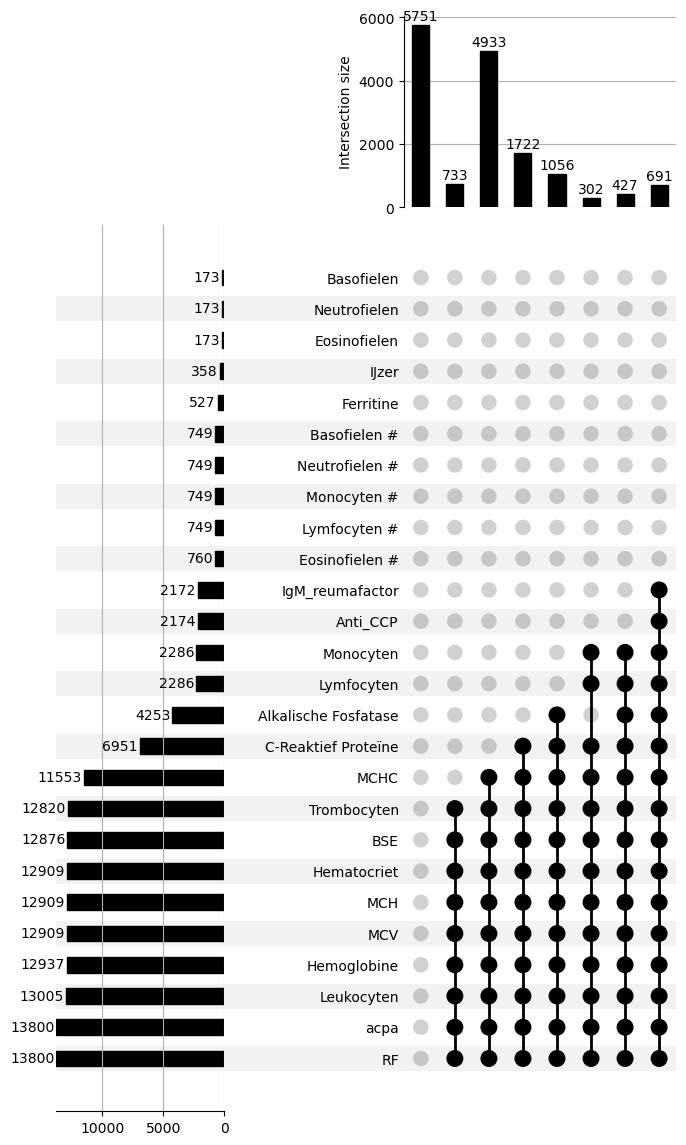

In [18]:
from upsetplot import UpSet, from_indicators
lab_features = ['Alkalische Fosfatase',
       'Anti_CCP', 'BSE', 'Basofielen', 'Basofielen #',
       'C-Reaktief Proteïne', 'Eosinofielen', 'Eosinofielen #', 'Ferritine',
       'Hematocriet', 'Hemoglobine', 'IJzer', 'RF', 'Leukocyten',
       'Lymfocyten', 'Lymfocyten #', 'MCH', 'MCHC', 'MCV', 'Monocyten',
       'Monocyten #', 'Neutrofielen', 'Neutrofielen #', 'Trombocyten', "acpa", "IgM_reumafactor"]
print(lab.columns)
x = test_mergasof[lab_features]
x = x>=0

UpSet(from_indicators(lambda df: df.select_dtypes(bool),
                      data=x),
      min_subset_size=300,
      show_counts=True,
     totals_plot_elements=5)

In [20]:
features = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP',
            #'Anti-CCP Kwant.',
            'BSE',
            #'C-Reaktief Proteïne',
            'Leukocyten',
            #'Hematocriet',
            'Hemoglobine',
            #'IgM reumafactor',
            #'MCH',
            #'MCHC',
            'MCV',
            'Trombocyten',
            #'Ferritine',
           ]

test_dataset = test_mergasof[["PATNR","DATUM"]+features].dropna()

In [21]:
test_dataset = test_mergasof[["PATNR","DATUM"]+features].dropna()
test_dataset = test_dataset.merge(das_old.groupby("PATNR").DATUM.min().reset_index().rename(columns={"DATUM":"baseline_date"}))
test_dataset["delta_days"] =(test_dataset.DATUM - test_dataset.baseline_date).dt.days
test_dataset = test_dataset.query("Leukocyten <=25")
multi_visits = test_dataset.query("delta_days <=550").groupby("PATNR").count().query("DATUM >=2").index
dataset = test_dataset.query("PATNR in @multi_visits").query("delta_days <=550")


In [22]:
from secret import ASCARA_ID

#dataset.query("delta_days == 0").query("PATNR not in @ASCARA_ID").query("delta_days <=550")

In [23]:
lab.columns

Index(['PATNR', 'Monster_Afname_Datumtijd', 'Alkalische Fosfatase', 'Anti_CCP',
       'Anti_CCP_kwant', 'BSE', 'Basofielen', 'Basofielen #',
       'C-Reaktief Proteïne', 'Eosinofielen', 'Eosinofielen #', 'Ferritine',
       'Hematocriet', 'Hemoglobine', 'IJzer', 'IgM_reumafactor', 'Leukocyten',
       'Lymfocyten', 'Lymfocyten #', 'MCH', 'MCHC', 'MCV', 'Monocyten',
       'Monocyten #', 'Neutrofielen', 'Neutrofielen #', 'Trombocyten',
       'acpa_pre', 'RF', 'acpa', 'seropos'],
      dtype='object')

In [24]:
symp = pd.read_csv(data_dir_old+"StringentPatSelection_SymptomDuration+Demographics.csv", sep="|")[["patnr","symptomDuration"]]


In [25]:
diagnoses = pd.read_csv("/exports/reum/nsteinz/code/NLP_project/diagnose_notes.csv", index_col=0)
diagnoses.authored_date = pd.to_datetime(diagnoses.authored_date)
diagnoses.groupby("PATNR").tail(2)
diagnoses["diag"] = diagnoses["diag"].str.strip("[]").astype(float)
diagnoses["diag_bool"] = (diagnoses["diag"] > 0.5) * 1
diagnoses
diagnoses.authored_date= pd.to_datetime(diagnoses.authored_date)
baseline = diagnoses.query("diag_bool == 1").sort_values("authored_date").groupby("PATNR").head(1)[["PATNR", "authored_date"]].rename(columns={"authored_date":"start_date"})
baseline = diagnoses.merge(baseline, on="PATNR")
baseline["days_nlp"]= (baseline.authored_date - baseline.start_date).dt.days
diagnoses = baseline.copy()

In [26]:
das = pd.read_csv(data_dir_old+"mannequine_file.csv")
das["ns"] = das.DATUM.copy().astype("str").apply(np.datetime64).astype("int")
das["DATUM"] = pd.to_datetime(das.DATUM)
start_datum = das.sort_values(["PATNR","DATUM"]).groupby("PATNR").head(1).reset_index(drop=True)[["PATNR","DATUM"]]
start_datum = start_datum.rename(columns={"DATUM":"START_DATUM"})
das = das.merge(start_datum,left_on="PATNR", right_on="PATNR").copy()
pat_info = pd.read_csv(data_dir_old+"NewPatSelection_Demographics_20221202.csv", sep="|")
pat_info["Sex"] = (pat_info.gender_code_original == "V")
pat_info.birthDate = pd.to_datetime(pat_info.birthDate).dt.date
das = das.merge(pat_info[["PATNR","Sex", "birthDate"]],left_on="PATNR", right_on="PATNR").copy()
das = das.merge(symp,left_on="PATNR", right_on="patnr", how= "left").copy()
das = das.groupby(["PATNR","DATUM"]).head(1)
das_test = das.copy()


In [27]:
pat_info = pat_info.merge(mapping_pid)

In [28]:
df = das.merge(pat_info)


In [29]:
PEC= df.sort_values("DATUM").groupby("patient_id").head(1)[['patient_id', "DATUM"]].rename(columns={'DATUM':"PEC"})
df = df.merge(PEC, on = "patient_id")
df["delta_time"] = (df.DATUM - df.PEC).dt.days


In [30]:
from datetime import timedelta
das_test = das.copy()[["PATNR", "DATUM"]]
das_test["start_time"] = das.sort_values("DATUM").groupby("PATNR").shift(1,fill_value=pd.to_datetime("2010-01-01")).DATUM + timedelta(seconds=1)
das_test
das_test["interval"] = pd.IntervalIndex.from_arrays(das_test['start_time'], das_test['DATUM'],closed="both")
das_test
diagnoses["interval"] = pd.IntervalIndex.from_arrays(diagnoses['authored_date'], diagnoses['authored_date'],closed="both")

In [31]:
das.sort_values("DATUM").groupby("PATNR").head(1).symptomDuration.describe()

count      496.000000
mean       758.331653
std       1690.901125
min      -1991.000000
25%         62.000000
50%        155.000000
75%        584.500000
max      12045.000000
Name: symptomDuration, dtype: float64

In [32]:
das["Age"] = np.floor((pd.to_datetime(das.START_DATUM) - pd.to_datetime(das.birthDate)).dt.days/365.25)


In [33]:

#das = das[~das.PATNR.isin(ascara_id)]
len(das.PATNR.unique())

1986

In [34]:
lab_ = pd.read_csv(data_dir_old+"NewPatSelection_Lab_20221202.csv", sep = "|")

lab_ = lab_.drop(lab_.query("uitslag_unit=='/uL'").index)
lab_ = lab_.drop(lab_.query("uitslag_unit=='/µL'").index)
lab_ = lab_.drop(lab_.query("test_naam_omschrijving=='Lymfocyten' & uitslag_unit == '%'").index)
lab_ = lab_.drop(lab_.query("test_naam_omschrijving=='Monocyten' & uitslag_unit == '%'").index)
lab_.drop(lab_.query("uitslag_unit=='10*6/L'").index)
lab_.drop(lab_.query("uitslag_unit=='x10^6/L'").index)
lab_copy = lab_.copy()
#print()
lab_.Monster_Afname_Datumtijd = pd.to_datetime(lab_.Monster_Afname_Datumtijd)
# fix some spelling mistakes
lab_.test_naam_omschrijving = (lab_.test_naam_omschrijving
        .copy()
        .replace("Hb", "Hemoglobine")
        .replace("Ht", "Hematocriet")
        .replace("Hematocriet [CKCL]", "Hematocriet")
        .replace("Hemoglobine [CKCL]", "Hemoglobine")
        .replace("C-Reactief Proteine", "C-Reaktief Proteïne")

       )

lab_.uitslag_value = (lab_.uitslag_value
                    .replace("NaN", 0)
                    .fillna(0)
                    .astype(np.float32))
#print(lab_.uitslag_text )
lab_.uitslag_text = pd.to_numeric(lab_.uitslag_text
                     .replace("Positief", 100)
                     .replace("Negative", 1)
                     .replace("Positive", 100)
                     .replace("Negatief", 1)
                     .replace(">340", 341)
                     .replace(">200", 201)
                     .replace("<3", 2)
                     .replace("<3.0", 2)  

                     ,errors='coerce'
                  ).fillna(0)

# dit veroorzaakt negatieve waardes
lab_.uitslag_value = (lab_.uitslag_value + lab_.uitslag_text)

lab_old= lab_.pivot_table(index=["PATNR","Monster_Afname_Datumtijd"], 
                columns="test_naam_omschrijving", 
                values="uitslag_value",
                ).reset_index()
lab_names = lab_old.columns[2:]
lab_old["IgM reumafactor"]
lab_old = lab_old.rename(columns={"Anti-CCP":"Anti_CCP", "Anti-CCP Kwant.":"Anti_CCP_kwant", 'IgM reumafactor':'IgM_reumafactor'})
#lab.query("PATNR == 304816915")
lab_old["Monster_Afname_Datumtijd"]=  pd.to_datetime(lab_old.Monster_Afname_Datumtijd).dt.date


In [35]:
lab_old["acpa_pre"] = (lab_old[["Anti_CCP","Anti_CCP_kwant"]].sum(axis=1, min_count=1) > 9) * 1

In [36]:
acpa = (lab_old.groupby("PATNR").acpa_pre.max()== 1).to_frame().rename(columns={"acpa_pre":"acpa"})
RF = (lab_old.groupby("PATNR").IgM_reumafactor.max()>= 20).to_frame().rename(columns={"IgM_reumafactor":"RF"})

In [37]:
lab_old = lab_old.merge(RF, how="left", left_on="PATNR", right_on="PATNR")
lab_old = lab_old.merge(acpa, how="left", left_on="PATNR", right_on="PATNR")

In [38]:
lab_old.groupby("PATNR").RF.max().sum()

899

In [39]:
lab_old.groupby("PATNR").acpa.max().sum()

949

In [40]:
lab_old["seropos"] = lab_old[["RF","acpa"]].sum(axis=1) >=1
lab_old.groupby("PATNR").seropos.max().sum()

1111

In [41]:
lab_old.MCV.describe()

count    40513.000000
mean        91.580939
std          8.976170
min          0.000000
25%         88.000000
50%         92.000000
75%         96.000000
max        132.000000
Name: MCV, dtype: float64

# drop because there is no das or lab value

In [42]:
no_lab = list(set(das.PATNR)-set(lab_old.PATNR))
no_das = list(set(lab_old.PATNR) - set(das.PATNR))
len(no_lab)


13

In [43]:
lab_old["ns"] = lab_old.Monster_Afname_Datumtijd.copy().astype("str").apply(np.datetime64).astype("int")

In [44]:
lab_pat = len(lab_old.PATNR.unique())
lab_pat

2096

In [45]:
#lab.groupby("PATNR").Anti_CCP.max()

In [46]:
lab_acpa = lab_old.groupby("PATNR").acpa.max().sum()
print(lab_acpa)
lab_acpa/lab_pat

949


0.4527671755725191

In [47]:
lab_rf= lab_old.groupby("PATNR").RF.max().sum()
print(lab_rf)
lab_rf/lab_pat

899


0.428912213740458

In [48]:
len(lab)

44019

In [49]:
lab = lab_old.query("BSE >=0 & Leukocyten>0")
len(lab)

35526

In [50]:
das["days"] = (pd.to_datetime(das.DATUM)-pd.to_datetime(das.START_DATUM)).dt.days


In [51]:
x = das.groupby("PATNR").count().DATUM

ids = x[x>1].reset_index().PATNR.unique()

das = das[das.PATNR.isin(ids)]
print(len(das))
len(das.PATNR.unique())

17090


1812

In [55]:
def merge_by_time(dataset : pd.DataFrame,
                  query : pd.DataFrame,
                  id_dataset: [int,str],
                  id_query: [int,str],
                  by_dataset : [str,int],
                  by_query : [str,int],
                  suffixes:list=["_das","_lab"],
                  max_days : [int,float]=10,
                  merge_how = "inner",
                  size:int = 1
                 ) -> pd.DataFrame:
    final_dataset = pd.DataFrame()
    
    _dataset = dataset.copy()
    _query = query.copy()
    
    _dataset["ns"] = _dataset[by_dataset].copy().astype("str").apply(np.datetime64).astype("int")
    _query["ns"] = _query[by_query].copy().astype("str").apply(np.datetime64).astype("int")
    
    
    for id_value in _query[id_query].unique():
        tree_query = _query[_query[id_query]==id_value].copy().reset_index()
        tree_dataset = _dataset[_dataset[id_dataset]==id_value].copy().reset_index()
        if tree_dataset.empty and merge_how == "inner":
            print(f"{id_value}: dataset is empty")
            continue
        elif tree_dataset.empty:
            merge = tree_query
        else:
            # make the nn tree and query the values    
            # this is the method to fine the clossed time neir the query
            tree = KDTree(tree_dataset["ns"].array.reshape(-1,1))
            res = tree.query(tree_query["ns"].array.reshape(-1,1),k=1)

            # link the query with the dataset
            tree_query["time"] = res[1]
            tree_query["delta_time"] = pd.to_timedelta(res[0].T[0],)

            merge = tree_query.merge(tree_dataset,
                                     how=merge_how,
                                     left_on="time",
                                     right_index=True,
                                     suffixes=suffixes
                                    )
            if merge_how =="inner":
                merge = merge[merge.delta_time < pd.Timedelta(max_days, unit="D")]
            else:
                #print(merge.delta_time)
                merge_ = merge[merge.delta_time < pd.Timedelta(max_days, unit="D")]
                merge = (tree_query[~merge.DATUM.isin(merge_.DATUM)])
                merge = pd.concat([merge,merge_], ignore_index=True,sort=False)
                
        if len(merge)<size:
            print(f"{id_value}: size to small")
            continue
        
        final_dataset = pd.concat([final_dataset, merge], ignore_index=True, sort=False )
    return final_dataset.drop(columns=["time", "delta_time"])

    

In [56]:

dataset = das.merge(meds,on=["PATNR","DATUM"], how="left").fillna(0)


# links the Lab values to the mannequine data if the labvalue is in 10 days of the consult (mannequin)
if there are multiple lab values close to the consult it will take the closed one

In [57]:
print(len(das.PATNR.unique()), "; totaal points: ", len(das))
dataset = merge_by_time(lab,das,
              "PATNR","PATNR",
              "Monster_Afname_Datumtijd","DATUM",
                        suffixes=["_lab", ""],
                    max_days = 10)

print(len(dataset.PATNR.unique()),  "; totaal points: ", len(dataset))

1812 ; totaal points:  17090
304817190: size to small
304818866: size to small
304821608: size to small
304821872: size to small
304823066: size to small
304825193: size to small
304830954: dataset is empty
304832545: size to small
304834635: dataset is empty
304838066: size to small
304843708: size to small
304844044: size to small
304844162: size to small
304845089: size to small
304848209: size to small
304850286: size to small
304854284: size to small
304855346: size to small
304857925: size to small
304858027: dataset is empty
304862136: size to small
304862407: size to small
304864038: size to small
304868498: size to small
1788 ; totaal points:  12399


6.934563758389261

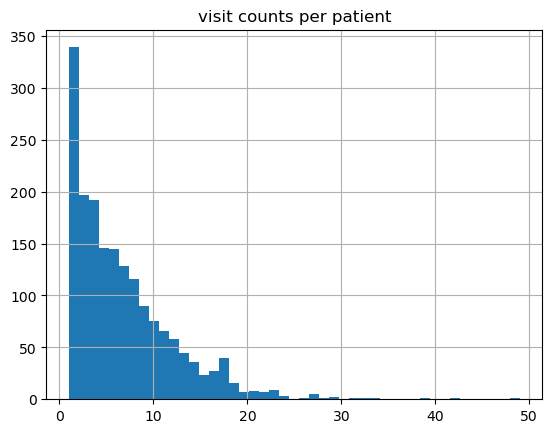

In [58]:
dataset.groupby("PATNR").count().DATUM.hist(bins=45)
plt.title('visit counts per patient')
dataset.groupby("PATNR").index.count().mean()

In [59]:
dataset.Monster_Afname_Datumtijd = pd.to_datetime(dataset.Monster_Afname_Datumtijd)

Text(0.5, 1.0, 'days between lab and consult')

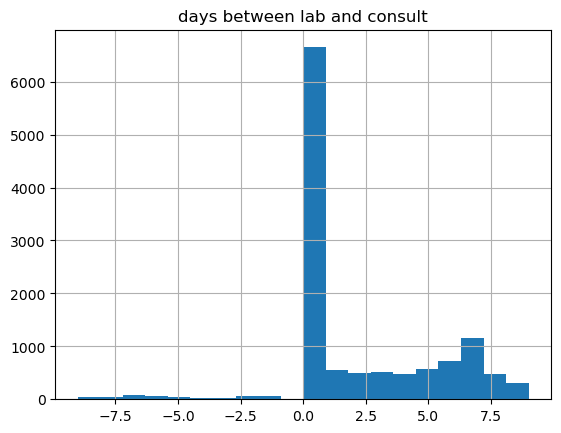

In [60]:
(dataset.DATUM - dataset.Monster_Afname_Datumtijd).dt.ceil("D").dt.days.hist(bins=20)
dataset[(dataset.DATUM - dataset.Monster_Afname_Datumtijd).dt.ceil("D").dt.days < -2 ]
plt.title('days between lab and consult')

In [61]:
len(dataset.PATNR.unique())

1788

Text(0.5, 1.0, 'days since first visits')

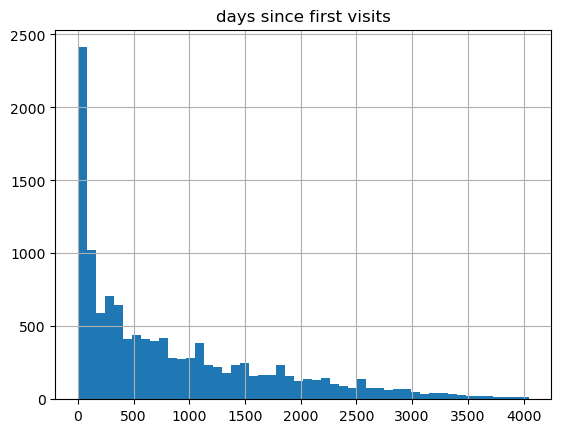

In [62]:
dataset.days.hist(bins=50)
dataset.days.describe()
plt.title('days since first visits')

In [63]:
len(dataset.PATNR.unique())

1788

In [64]:
dataset["dmard_usage"] = dataset[dmards].sum(axis=1) > 0
dataset["no_meds"] = ~dataset["dmard_usage"]

In [65]:
features = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP',
            #'Anti-CCP Kwant.',
            'BSE',
            #'C-Reaktief Proteïne',
            'Leukocyten',
            #'Hematocriet',
            'Hemoglobine',
            #'IgM reumafactor',
            #'MCH',
            #'MCHC',
            'MCV',
            'Trombocyten',
            #'Ferritine',
           ]

In [66]:
#dataset.query("Leukocyten > 25").Leukocyten
#dataset[features].query("MCV >20")

In [68]:
len(dataset[dataset.PATNR.isin(ASCARA_ID)].PATNR.unique())
print("begin:", len(dataset.PATNR.unique()), "; totaal points: ", len(dataset))
data_use = dataset.query("0 < Leukocyten < 25")
print("-high leuko:", len(data_use.PATNR.unique()), "; totaal points: ", len(data_use))
#data_use = data_use.query(" MCV > 25")
pids = set(data_use.PATNR.unique())
data_use = data_use.query("0<= days <=550")
print("-more than 550 days: p:", len(data_use.PATNR.unique()), "; totaal points: ", len(data_use))
ids = (data_use.query("days==0").PATNR.unique())
data_use = data_use.loc[data_use.PATNR.isin(ids)]
print("-has a baseline visit: ", len(data_use.PATNR.unique()), "; totaal points: ", len(data_use))
pids_na = set(data_use.PATNR.unique())
z = (pids-pids_na)
length_data = data_use.groupby("PATNR").count()

ids= length_data.query("index_lab >1").reset_index().PATNR.unique()
data_use = data_use[data_use.PATNR.isin(ids)]
data_use.days.describe()
data_use[features]
data_use.Leukocyten.describe()
print("-has 2 or more visits: ",len(data_use.PATNR.unique()) ,"; totaal points: ", len(data_use))

begin: 1788 ; totaal points:  12399
-high leuko: 1788 ; totaal points:  12391
-more than 550 days: p: 1747 ; totaal points:  6107
-has a baseline visit:  1554 ; totaal points:  5575
-has 2 or more visits:  1309 ; totaal points:  5330


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer

In [ ]:
#patients that have medication assigned before there first consultation based on hix data.
#pd.read_csv("all_problems.csv",).PATNR

In [ ]:
#problem_patients = pd.read_csv("all_problems.csv",).PATNR.values
#problem_patients

In [69]:
#data_used = data_use[["PATNR","DATUM", "days"]+features]
ascara_data = data_use[data_use.PATNR.isin(ASCARA_ID)]
data_use_final = data_use[~data_use.PATNR.isin(ASCARA_ID)]
#data_use_final = data_use_final[~data_use.PATNR.isin(problem_patients)]
data_use_final.to_csv(results_dir + "merged_new_data.csv", index=False)
ascara_data.to_csv(results_dir + "ascara_data.csv", index=False)

In [70]:
print(" after last filter stap: ",len(data_use_final.PATNR.unique()) ,"; totaal points: ", len(data_use_final))

 after last filter stap:  1274 ; totaal points:  5089


<Axes: >

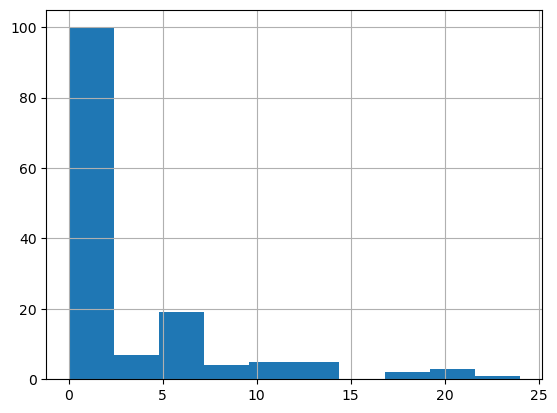

In [71]:
data_use_final.query("PATNR not in @datasamples_use.PATNR.unique()").SJC_28.hist()

In [72]:
dataset.to_csv(results_dir + "full_merged_data.csv", index=False)

/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

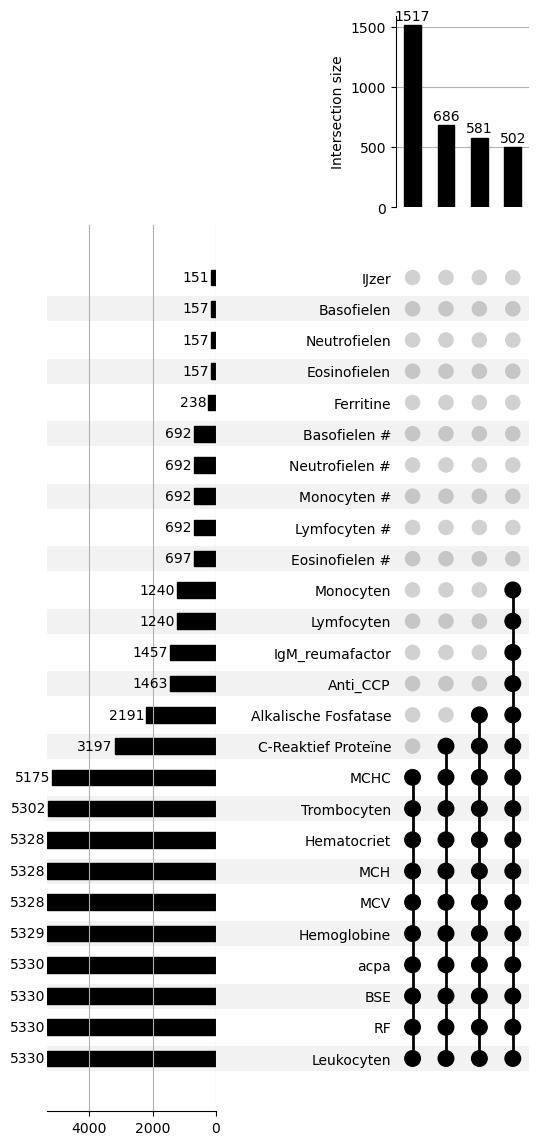

In [73]:
from upsetplot import UpSet, from_indicators
lab_features = ['Alkalische Fosfatase',
       'Anti_CCP', 'BSE', 'Basofielen', 'Basofielen #',
       'C-Reaktief Proteïne', 'Eosinofielen', 'Eosinofielen #', 'Ferritine',
       'Hematocriet', 'Hemoglobine', 'IJzer', 'RF', 'Leukocyten',
       'Lymfocyten', 'Lymfocyten #', 'MCH', 'MCHC', 'MCV', 'Monocyten',
       'Monocyten #', 'Neutrofielen', 'Neutrofielen #', 'Trombocyten', "acpa", "IgM_reumafactor"]
x = data_use[lab_features]
x = x>=0
UpSet(from_indicators(lambda df: df.select_dtypes(bool),
                      data=x),
      min_subset_size=300,
      show_counts=True,
     totals_plot_elements=5)